Running scenario: Base
Running scenario: High Demand
Running scenario: Low Demand
Running scenario: No charging
Running scenario: Uniform charging profile


C:\Users\aengholm\AppData\Local\Temp\ipykernel_129052\1798236288.py:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scenario_names, y=avg_prices, palette="viridis")


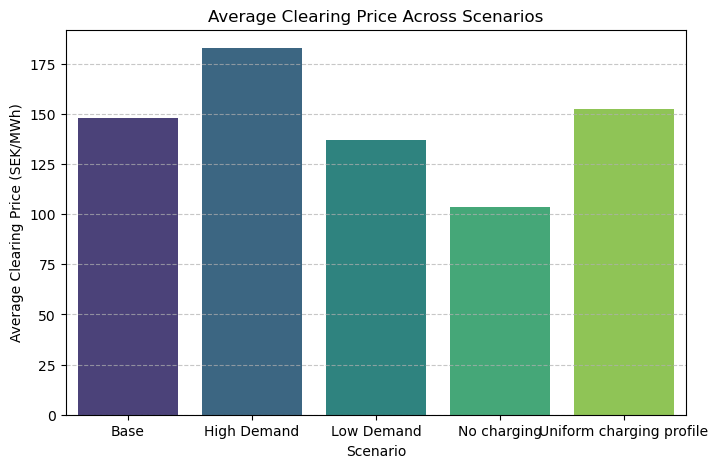

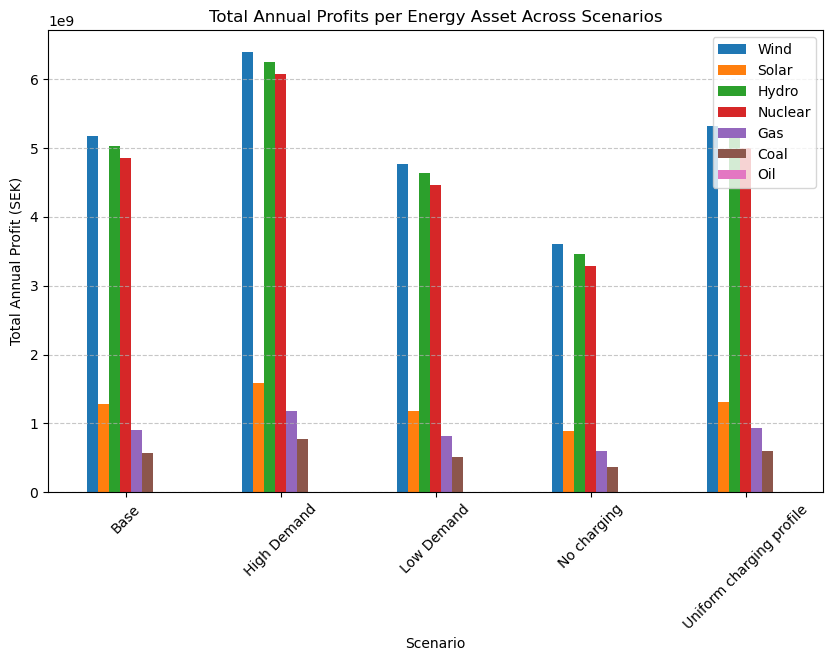

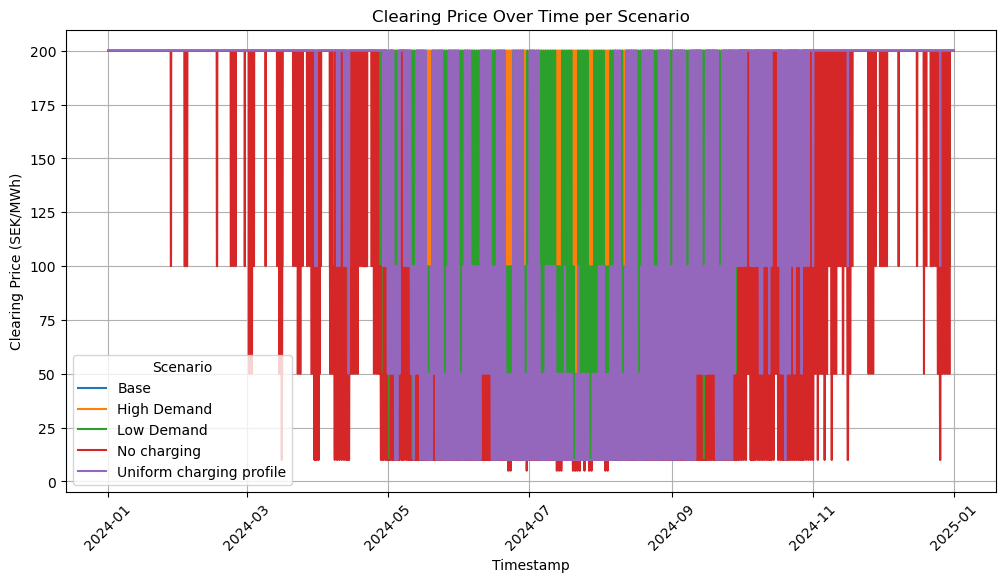

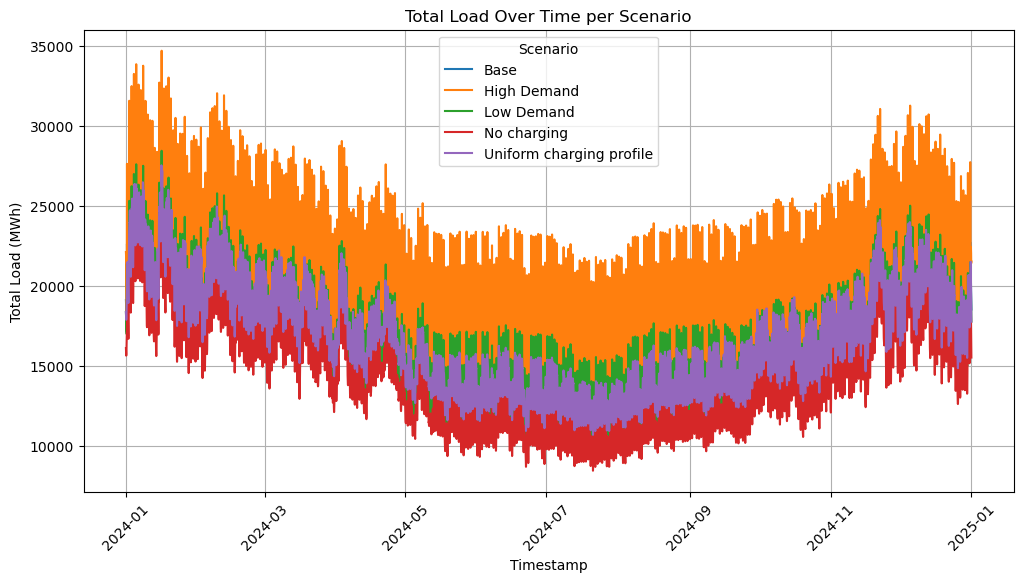

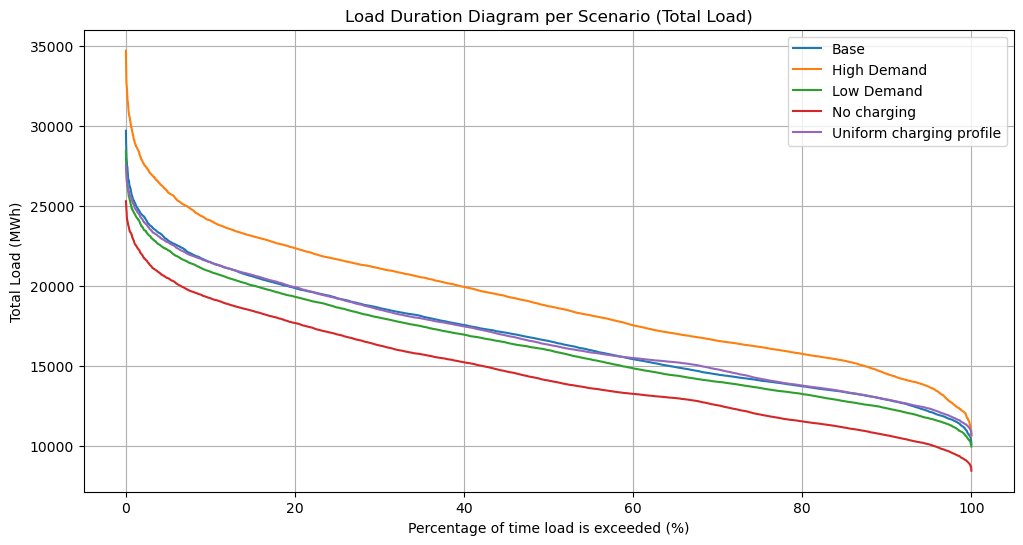

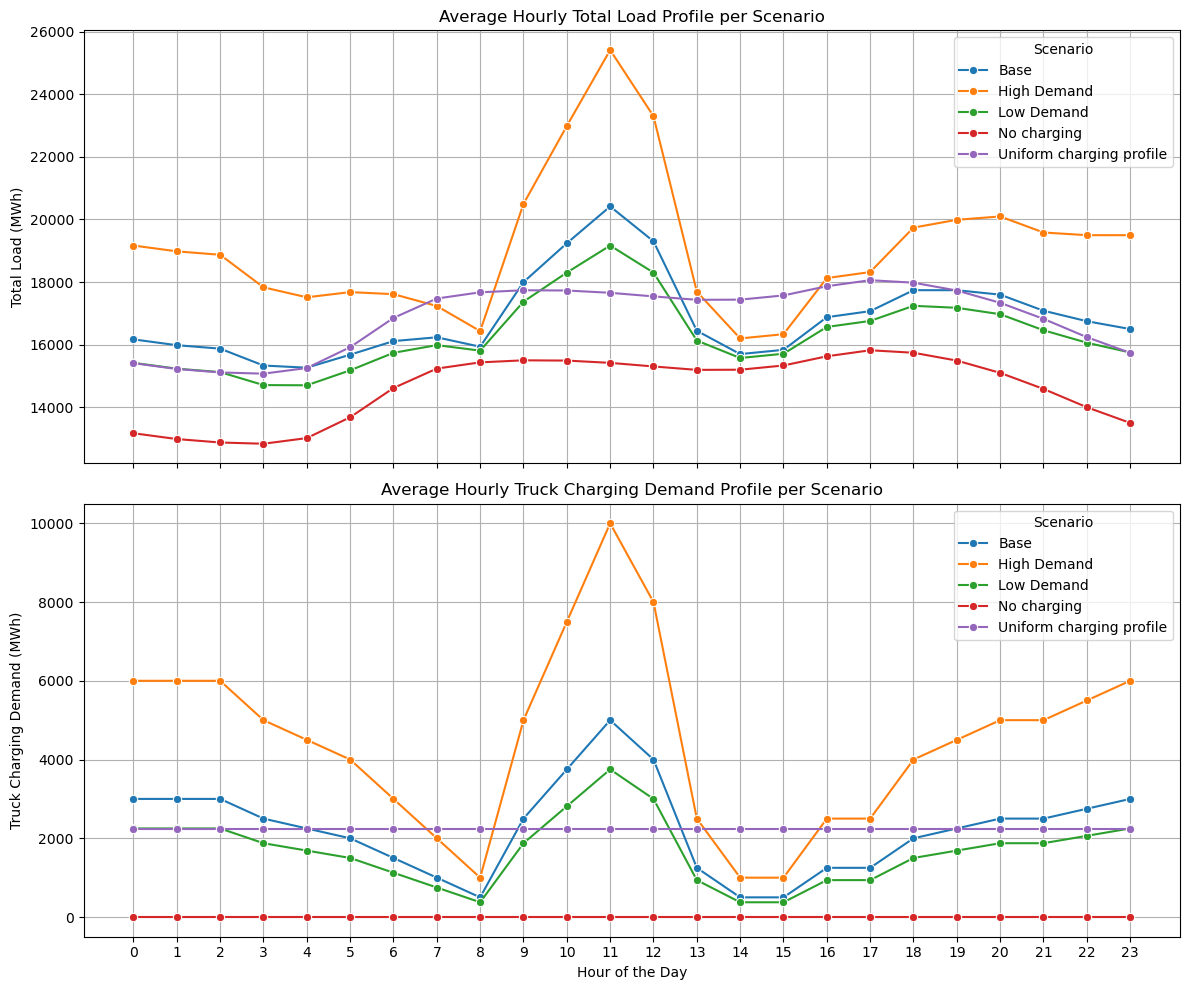

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 12 14:08:56 2025

@author: aengholm
"""
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# =============================================================================
# 1. Data Loading and Preprocessing (Load Once)
# =============================================================================

def load_data(file_path):
    """Load and preprocess the consumption data."""
    df = pd.read_csv(file_path, delimiter=';')
    # Convert the 'Load Profile [MWh]' column to numeric and flip sign
    df['Load Profile [MWh]'] = -df['Load Profile [MWh]'].str.replace(',', '.', regex=False).astype(float)
    # Rename and convert timestamp
    df.rename(columns={'Date/Time SNT': 'Timestamp'}, inplace=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d.%m.%Y/%H:%M')
    # Aggregate to hourly level
    df = df.resample('H', on='Timestamp').sum(numeric_only=True).reset_index()
    return df


# Load the CSV data once
file_path = "./data/2024_svk_se.xlsx"

df_xlsx_cleaned = pd.read_excel(file_path, sheet_name="Förb + prod i Sverige", skiprows=6)
df_xlsx_cleaned.rename(columns={
    "Tid": "Timestamp",
    "Total förbrukning": "Load Profile [MWh]",
    "Vindkraft": "Wind Power [MWh]",
    "Vattenkraft": "Hydro Power [MWh]",
    "Kärnkraft": "Nuclear Power [MWh]",
    "Övr.värmekraft": "Other Thermal Power [MWh]",
    "Ospec. prod.": "Unspecified Power [MWh]",
    "Solkraft": "Solar Power [MWh]",
    "Energilager": "Battery Storage [MWh]",
    "Total produktion": "Total Production [MWh]",
    "Import/export": "Net Import Export [MWh]"
}, inplace=True)

# Convert the timestamp column to datetime format
df_xlsx_cleaned["Timestamp"] = pd.to_datetime(df_xlsx_cleaned["Timestamp"])

# Ensure the load profile is positive (flip sign if necessary)
df_xlsx_cleaned["Load Profile [MWh]"] = abs(df_xlsx_cleaned["Load Profile [MWh]"])

# Update base_df to use the new cleaned load profile
base_df = df_xlsx_cleaned[["Timestamp", "Load Profile [MWh]"]].copy()


# =============================================================================
# 2. Define Generation Assets and Helper Functions
# =============================================================================

# Define power generation assets (Capacity in MWh, Marginal Cost in SEK/MWh)
generation_assets = pd.DataFrame({
    "Type": ["Wind", "Solar", "Hydro", "Nuclear", "Gas", "Coal", "Oil"],
    "Capacity": [4000, 1000, 4000, 4000, 1000, 1000, 500],
    "Marginal Cost": [1, 3, 5, 10, 50, 100, 200]
})
# Sort assets by marginal cost (merit order)
generation_assets = generation_assets.sort_values(by="Marginal Cost").reset_index(drop=True)


def calculate_clearing_price(demand):
    """
    Determine the market clearing price by dispatching assets in merit order
    until the cumulative capacity meets the demand.
    """
    supplied = 0
    for _, row in generation_assets.iterrows():
        supplied += row["Capacity"]
        if supplied >= demand:
            return row["Marginal Cost"]
    return generation_assets["Marginal Cost"].max()


def calculate_operating_profit(row):
    """
    For a given hour (row), dispatch generation assets in merit order.
    Operating profit for each asset is:
      (dispatched energy * clearing price) - (dispatched energy * marginal cost)
    """
    supplied = 0
    profits = {}
    for _, asset in generation_assets.iterrows():
        if supplied < row["Total Load [MWh]"]:
            supply_from_asset = min(asset["Capacity"], row["Total Load [MWh]"] - supplied)
            revenue = supply_from_asset * row["Clearing Price (SEK/MWh)"]
            cost = supply_from_asset * asset["Marginal Cost"]
            profits[asset["Type"]] = revenue - cost
            supplied += supply_from_asset
        else:
            profits[asset["Type"]] = 0
    return profits


# =============================================================================
# 3. Wrap the Simulation into a Function with a Charging Profile Parameter
# =============================================================================

def run_simulation(charging_profile, base_df, scenario_name="Default"):
    """
    Run the electricity market simulation for a given truck charging profile.

    Parameters:
      - charging_profile: a numpy array (length 24) representing hourly charging demand (MWh)
      - base_df: pre-loaded DataFrame with the consumption data.
      - scenario_name: label for the scenario.

    Returns:
      A dictionary containing the scenario name, the simulation DataFrame,
      the average clearing price, and total annual profits per asset.
    """
    # Work on a copy so as not to modify the original DataFrame
    df = base_df.copy()

    # Expand the 24-hour charging profile to match all days in the dataset
    num_days = df['Timestamp'].dt.date.nunique()
    df['Truck Charging Demand [MWh]'] = np.tile(charging_profile, num_days)[:len(df)]

    # Calculate the total load (original load plus truck charging demand)
    df['Total Load [MWh]'] = df['Load Profile [MWh]'] + df['Truck Charging Demand [MWh]']

    # Determine the market clearing price for each hour
    df["Clearing Price (SEK/MWh)"] = df["Total Load [MWh]"].apply(calculate_clearing_price)

    # Compute operating profit per asset for each hour
    profit_results = df.apply(calculate_operating_profit, axis=1).apply(pd.Series)
    profit_results.columns = [f"Profit ({col})" for col in profit_results.columns]
    df = pd.concat([df, profit_results], axis=1)

    # Summary statistics
    average_clearing_price = df["Clearing Price (SEK/MWh)"].mean()
    total_profits = df[[col for col in df.columns if "Profit" in col]].sum()

    # Add a scenario column for later visualization
    df['Scenario'] = scenario_name

    return {
        "scenario": scenario_name,
        "df": df,
        "average_clearing_price": average_clearing_price,
        "total_profits": total_profits
    }


# =============================================================================
# 4. Scenario Testing Tool (Updated with Load Duration Diagram and Demand Profiles)
# =============================================================================

def run_scenarios(scenarios, base_df):
    """
    Run multiple simulation scenarios and visualize results.

    Parameters:
      - scenarios: a dictionary where keys are scenario names and values are 
                   24-hour truck charging profiles (numpy arrays).
      - base_df: the pre-loaded consumption data.

    Returns:
      A dictionary mapping scenario names to their simulation results.
    """
    results = {}
    df_list = []  # To store DataFrames from each simulation run for combined plotting

    for scenario_name, charging_profile in scenarios.items():
        print(f"Running scenario: {scenario_name}")
        res = run_simulation(charging_profile, base_df, scenario_name=scenario_name)
        results[scenario_name] = res
        df_list.append(res["df"])

    # Visualization: Average Clearing Price Across Scenarios
    plt.figure(figsize=(8, 5))
    scenario_names = list(results.keys())
    avg_prices = [results[name]["average_clearing_price"] for name in scenario_names]
    sns.barplot(x=scenario_names, y=avg_prices, palette="viridis")
    plt.xlabel("Scenario")
    plt.ylabel("Average Clearing Price (SEK/MWh)")
    plt.title("Average Clearing Price Across Scenarios")
    plt.grid(axis='y', linestyle="--", alpha=0.7)
    plt.show()

    # Visualization: Total Annual Profits per Energy Asset Across Scenarios
    profit_data = {}
    for scenario_name, res in results.items():
        profits = res["total_profits"]
        # Clean asset names by removing the "Profit (" prefix and ")" suffix
        profits.index = [name.replace("Profit (", "").replace(")", "") for name in profits.index]
        profit_data[scenario_name] = profits
    profit_df = pd.DataFrame(profit_data).T
    profit_df.plot(kind="bar", figsize=(10, 6))
    plt.xlabel("Scenario")
    plt.ylabel("Total Annual Profit (SEK)")
    plt.title("Total Annual Profits per Energy Asset Across Scenarios")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle="--", alpha=0.7)
    plt.show()

    # Visualization: Clearing Price Over Time per Scenario
    combined_df = pd.concat(df_list)
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=combined_df, x="Timestamp", y="Clearing Price (SEK/MWh)", hue="Scenario", palette="tab10")
    plt.xlabel("Timestamp")
    plt.ylabel("Clearing Price (SEK/MWh)")
    plt.title("Clearing Price Over Time per Scenario")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Visualization: Total Load Over Time per Scenario
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=combined_df, x="Timestamp", y="Total Load [MWh]", hue="Scenario", palette="tab10")
    plt.xlabel("Timestamp")
    plt.ylabel("Total Load (MWh)")
    plt.title("Total Load Over Time per Scenario")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Visualization: Load Duration Diagram per Scenario (Total Load)
    plt.figure(figsize=(12, 6))
    for scenario_name, res in results.items():
        df = res["df"]
        # Sort total load values in descending order
        sorted_load = df["Total Load [MWh]"].sort_values(ascending=False).reset_index(drop=True)
        # Create a normalized time index (as percentage of hours)
        time_fraction = (sorted_load.index + 1) / len(sorted_load) * 100  # from 0 to 100%
        plt.plot(time_fraction, sorted_load, label=scenario_name)
    plt.xlabel("Percentage of time load is exceeded (%)")
    plt.ylabel("Total Load (MWh)")
    plt.title("Load Duration Diagram per Scenario (Total Load)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # New Visualization: Average Hourly Demand Profiles per Scenario for Total Load and Truck Charging Demand
    # Create an 'Hour' column based on the Timestamp
    combined_df['Hour'] = combined_df['Timestamp'].dt.hour
    # Group by Scenario and Hour, and compute the average Total Load
    avg_total_profile = combined_df.groupby(['Scenario', 'Hour'])['Total Load [MWh]'].mean().reset_index()
    # Group by Scenario and Hour, and compute the average Truck Charging Demand
    avg_charging_profile = combined_df.groupby(['Scenario', 'Hour'])[
        'Truck Charging Demand [MWh]'].mean().reset_index()

    # Plot both profiles in subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    sns.lineplot(data=avg_total_profile, x='Hour',
                 y='Total Load [MWh]', hue='Scenario', palette="tab10", marker="o", ax=axes[0])
    axes[0].set_title("Average Hourly Total Load Profile per Scenario")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Total Load (MWh)")
    axes[0].set_xticks(range(0, 24))
    axes[0].grid(True)

    sns.lineplot(data=avg_charging_profile, x='Hour',
                 y='Truck Charging Demand [MWh]', hue='Scenario', palette="tab10", marker="o", ax=axes[1])
    axes[1].set_title("Average Hourly Truck Charging Demand Profile per Scenario")
    axes[1].set_xlabel("Hour of the Day")
    axes[1].set_ylabel("Truck Charging Demand (MWh)")
    axes[1].set_xticks(range(0, 24))
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    return results


# =============================================================================
# 5. Define and Run Scenarios
# =============================================================================


max_p = 5000  # Peak power (MWh at the hour with factor 1.0)

# Base profile factors (24-hour pattern)
base_factors = np.array([
    0.60, 0.60, 0.60, 0.50,
    0.45, 0.40, 0.30, 0.20,
    0.10, 0.50, 0.75, 1.00,
    0.80, 0.25, 0.10, 0.10,
    0.25, 0.25, 0.40, 0.45,
    0.50, 0.50, 0.55, 0.60
])

# Create the base charging profile (in MWh each hour)
base_charging_profile = base_factors * max_p

# Compute total daily energy from the base profile
base_total_daily = base_charging_profile.sum()

# Compute the average power needed each hour to match the same total
average_power = base_total_daily / 24.0

# Build a uniform 24-hour profile that matches the total daily energy
uniform_charging_profile = np.full(24, average_power)


# High Demand scenario: 50% increase in charging demand
high_demand_profile = base_charging_profile * 2

# Low Demand scenario: 25% reduction in charging demand
low_demand_profile = base_charging_profile * 0.75

# No charging demand scenario
no_demand_profile = base_charging_profile * 0


# Assemble scenarios into a dictionary
scenarios = {
    "Base": base_charging_profile,
    "High Demand": high_demand_profile,
    "Low Demand": low_demand_profile,
    "No charging": no_demand_profile,
    "Uniform charging profile": uniform_charging_profile,
}

# Run all scenarios and visualize the results
results = run_scenarios(scenarios, base_df)
